## Analysis of FF Cerebellum preprocessed with Scanpy then SVG identification with squidpy

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import csv
from sklearn.metrics.pairwise import cosine_distances
import sys

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2
print(sys.version)

3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]


In [2]:
ff_human_cerebellum = sc.datasets.visium_sge('Parent_Visium_Human_Cerebellum')
ff_human_cerebellum.var_names_make_unique()

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#Calculate some QC metrics for the data
ff_human_cerebellum.var["mt"] = ff_human_cerebellum.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(ff_human_cerebellum, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


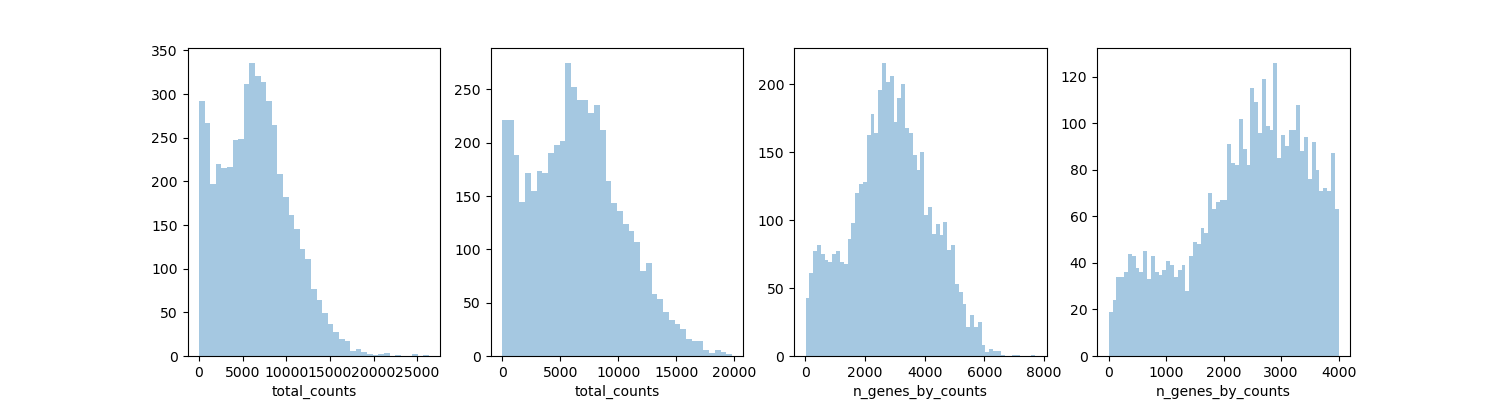

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


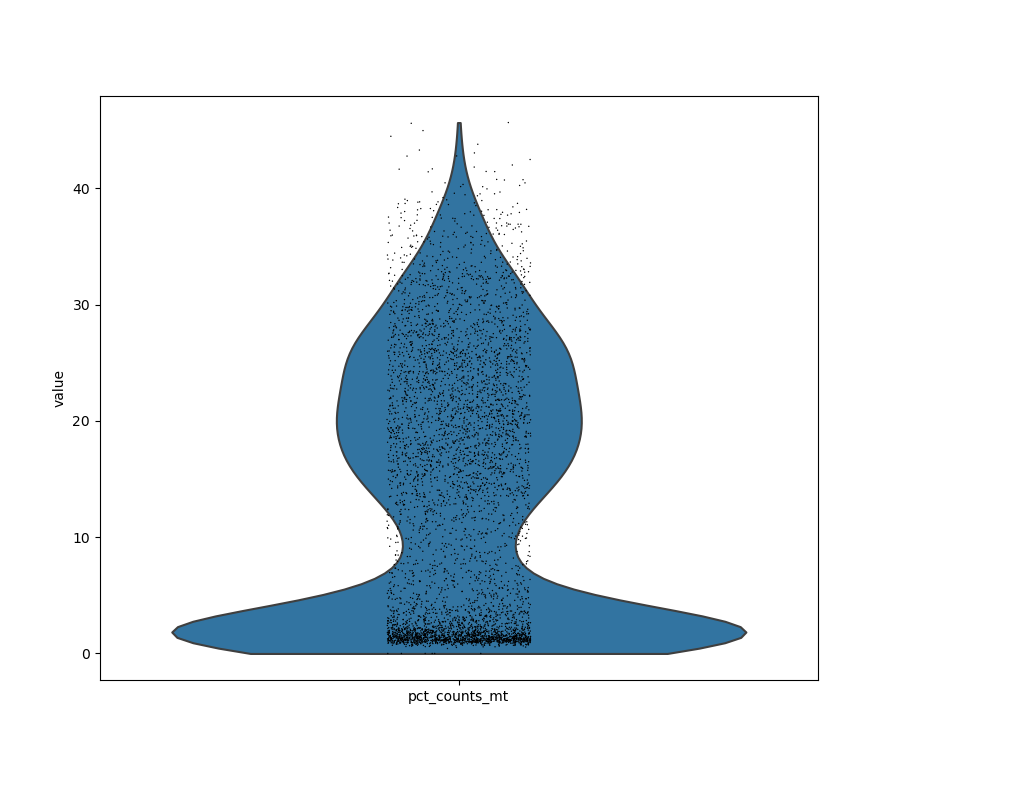

In [4]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ff_human_cerebellum.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_cerebellum.obs["total_counts"][ff_human_cerebellum.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ff_human_cerebellum.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ff_human_cerebellum.obs["n_genes_by_counts"][ff_human_cerebellum.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ff_human_cerebellum,['pct_counts_mt'])

In [5]:
ff_human_cerebellum

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#Perform some filtering
sc.pp.filter_cells(ff_human_cerebellum, min_counts=2000)
print(f'Number of cells after min count filter: {ff_human_cerebellum.n_obs}')
sc.pp.filter_cells(ff_human_cerebellum, max_counts=15000)
print(f'Number of cells after max count filter: {ff_human_cerebellum.n_obs}')
ff_human_cerebellum = ff_human_cerebellum[ff_human_cerebellum.obs["pct_counts_mt"] <= 15]
print(f"#cells after MT filter: {ff_human_cerebellum.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_human_cerebellum, min_cells=10)
print(f'Number of genes after cell filter: {ff_human_cerebellum.n_vars}')
sc.pp.filter_cells(ff_human_cerebellum, min_genes = 2000)
print(f'Number of cells after gene filter: {ff_human_cerebellum.n_obs}')

Number of cells after min count filter: 4215
Number of cells after max count filter: 4093
#cells after MT filter: 1720
Number of genes after cell filter: 16435
Number of cells after gene filter: 1459


/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [7]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_human_cerebellum, inplace=True)
sc.pp.log1p(ff_human_cerebellum)
sc.pp.highly_variable_genes(ff_human_cerebellum, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


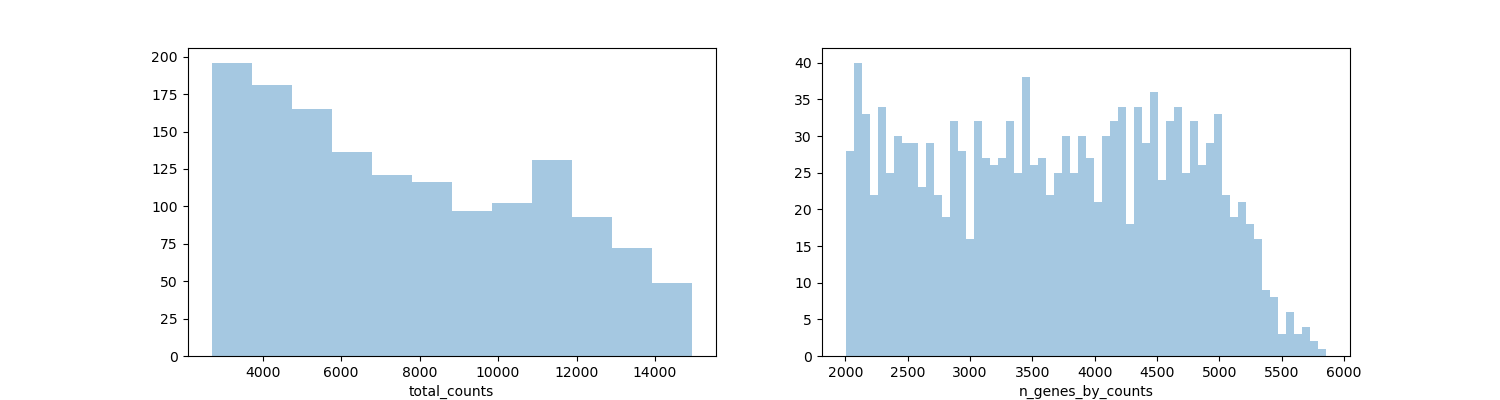

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [8]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ff_human_cerebellum.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_cerebellum.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [9]:
#Perform next steps in cluster identification
sc.pp.pca(ff_human_cerebellum,n_comps=20)
sc.pp.neighbors(ff_human_cerebellum)
sc.tl.umap(ff_human_cerebellum)
sc.tl.leiden(ff_human_cerebellum, key_added='clusters')

<IPython.core.display.Javascript object>


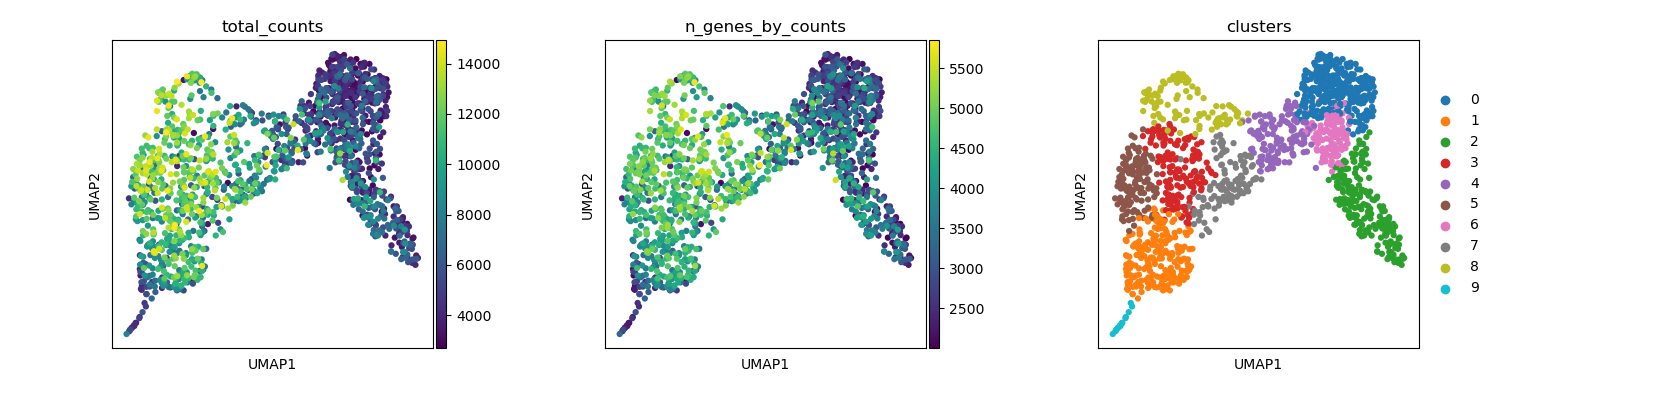

In [10]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ff_human_cerebellum, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


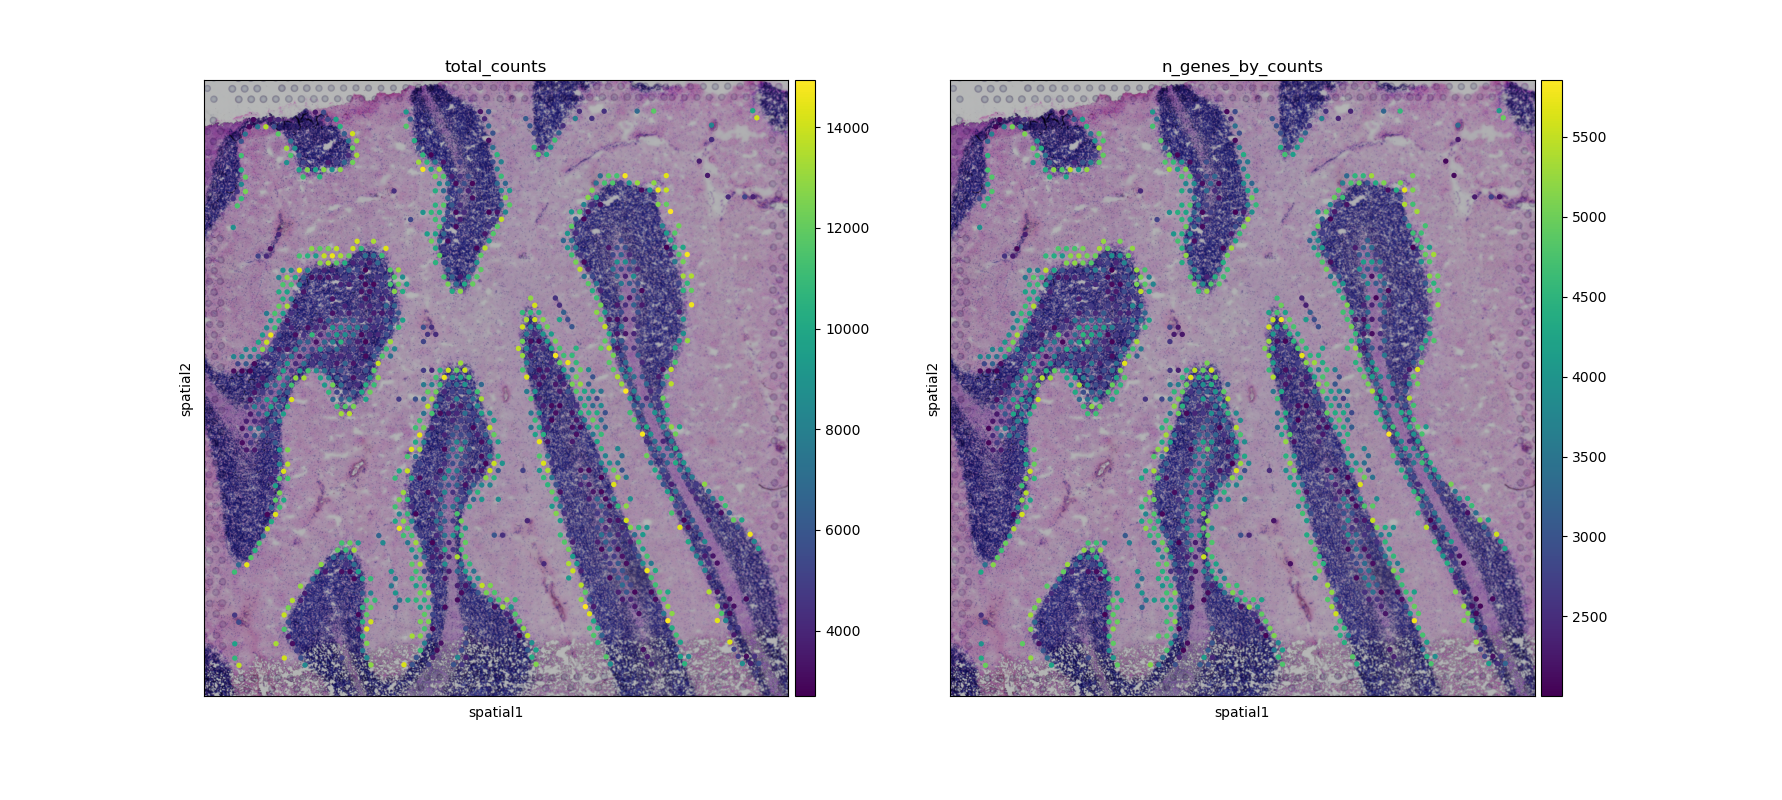

In [11]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ff_human_cerebellum, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


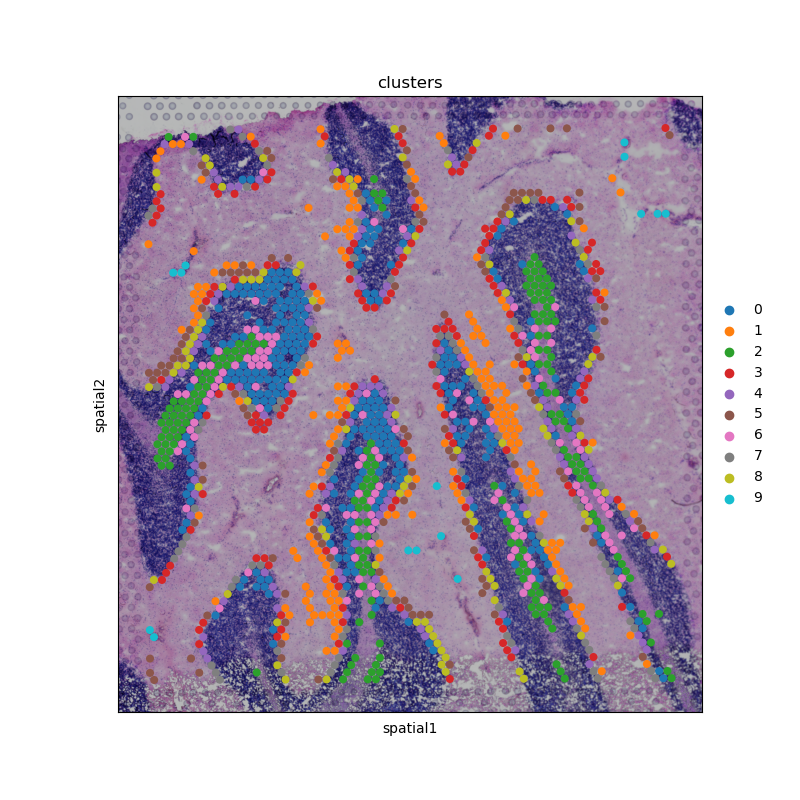

In [12]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ff_human_cerebellum, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


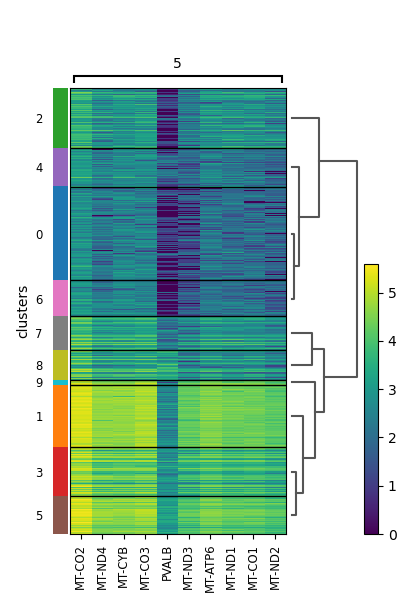

In [13]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ff_human_cerebellum, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ff_human_cerebellum, groups="5", n_genes=10, groupby="clusters")

### Write out necessary files

In [14]:
##write this AnnData object to something readable in Seurat - should be h5ad file
ff_human_cerebellum.write_h5ad(filename='ff_human_cerebellum.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [15]:
ff_human_cerebellum.write_csvs("ff_human_cerebellum",skip_data=False)

### Identify SVGs with Squidpy

In [17]:
##Compute Moran's I score to determine the spatial variability of certain genes - This runs it just on HVGs - run on all
sq.gr.spatial_neighbors(ff_human_cerebellum, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    ff_human_cerebellum,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
ff_human_cerebellum.uns["moranI"].head(10)

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
 27%|█████████████████████▏                                                        | 4475/16435 [00:12<00:33, 360.10it/s]


 56%|███████████████████████████████████████████▊                                  | 9239/16435 [00:26<00:20, 356.62it/s]


 85%|█████████████████████████████████████████████████████████████████▌           | 14004/16435 [00:39<00:07, 335.85it/s]


 20%|███████████████▏                                                              | 3212/16435 [00:06<00:25, 512.56it/s]


 60%|██████████████████████████████████████████████▊                               | 9863/16435 [00:19<00:13, 485.36it/s]


 63%|████████████████████████████████████████████████▊                            | 10427/16435 [00:20<00:12, 485.85it/s]/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)

 99%|████████████████████████████████████████████████████████████████████████████ | 16233/16435 [00:33<00:00, 459.25it/s]


 36%|████████████████████████████▍                                                 | 5992/16435 [00:12<00:22, 468.59it/s]


 75%|█████████████████████████████████████████████████████████▌                   | 12294/16435 [00:26<00:08, 471.90it/s]


 12%|█████████▌                                                                    | 2003/16435 [00:04<00:31, 461.87it/s]


 51%|███████████████████████████████████████▍                                      | 8309/16435 [00:17<00:17, 464.93it/s]


 85%|█████████████████████████████████████████████████████████████████            | 13889/16435 [00:32<00:05, 426.30it/s]


 19%|███████████████                                                               | 3169/16435 [00:07<00:29, 453.75it/s]


 56%|███████████████████████████████████████████▍                                  | 9158/16435 [00:20<00:16, 438.92it/s]


 92%|███████████████████████████████████████████████████████████████████████▏     | 15191/16435 [00:34<00:02, 451.49it/s]


 17%|█████████████▎                                                                | 2801/16435 [00:10<00:51, 265.66it/s]


 39%|██████████████████████████████▎                                               | 6387/16435 [00:24<00:39, 254.96it/s]


 60%|███████████████████████████████████████████████                               | 9916/16435 [00:37<00:27, 234.71it/s]


 82%|██████████████████████████████████████████████████████████████▉              | 13427/16435 [00:51<00:11, 251.11it/s]


  4%|██▉                                                                            | 610/16435 [00:01<00:46, 343.35it/s]


 32%|█████████████████████████                                                     | 5292/16435 [00:15<00:32, 344.08it/s]


 61%|███████████████████████████████████████████████▍                              | 9984/16435 [00:28<00:18, 348.37it/s]


 89%|████████████████████████████████████████████████████████████████████▍        | 14612/16435 [00:42<00:05, 351.12it/s]


 15%|███████████▍                                                                  | 2401/16435 [00:07<00:42, 333.73it/s]


 40%|███████████████████████████████▍                                              | 6621/16435 [00:21<00:36, 267.22it/s]


 66%|██████████████████████████████████████████████████▊                          | 10843/16435 [00:35<00:17, 325.72it/s]


 93%|███████████████████████████████████████████████████████████████████████▎     | 15229/16435 [00:48<00:03, 343.54it/s]


 19%|██████████████▉                                                               | 3141/16435 [00:09<00:41, 320.22it/s]


 45%|███████████████████████████████████▎                                          | 7448/16435 [00:23<00:26, 334.79it/s]


 72%|███████████████████████████████████████████████████████▌                     | 11864/16435 [00:36<00:13, 331.57it/s]


 99%|████████████████████████████████████████████████████████████████████████████▎| 16276/16435 [00:50<00:00, 331.98it/s]


 26%|███████████████████▉                                                          | 4206/16435 [00:12<00:36, 333.36it/s]


 53%|█████████████████████████████████████████                                     | 8660/16435 [00:26<00:23, 335.67it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 13143/16435 [00:39<00:10, 321.39it/s]


Models: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [07:34<00:00, 45.50s/it]


CPU times: user 46min 31s, sys: 8min 38s, total: 55min 9s
Wall time: 7min 46s


In [18]:
##Run moran's I on all genes not just HVGs
sq.gr.spatial_autocorr(ff_human_cerebellum, genes=ff_human_cerebellum.var_names, use_raw=False, mode="moran")

moran_I = pd.DataFrame(ff_human_cerebellum.uns['moranI'].sort_values(ascending=False,by=['I']))

##Sort this so corrected pvalue is above 0.05 and I is above 0.5
moran_I = moran_I[moran_I['pval_norm_fdr_bh'] <=0.05]

##The expected value under Moran's spatial autocorrelation is E(I) = -1/(N-1) where N is number of samples or in this case genes
moran_I = moran_I[moran_I['I'] > 0.1]

FSV  M        g           l  max_delta       max_ll  max_mu_hat  \
11061  0.357289  4  CACNA1G  254.692403   1.784657  -982.503261    0.456728   
11095  0.650771  4     PCP2  254.692403   0.532404 -1680.505317    1.497000   
11090  0.313424  4    RPL36  254.692403   2.173277 -1231.222034    1.832881   
11088  0.302358  4     TLE2  254.692403   2.289135 -1361.746379    1.103712   
11084  0.284657  4    RPS15  254.692403   2.493164  -817.926264    2.598286   
...         ... ..      ...         ...        ...          ...         ...   
7325   0.659081  4    RPP25   68.500000   0.517083   377.385262    0.059367   
12650  0.083334  4     CTSD  946.981318  10.159850 -1293.965032    0.899025   
6275   0.580321  4     LRP1   68.500000   0.722932 -1256.558115    1.035026   
6500   0.651916  4   DYNLL1   68.500000   0.533753 -1233.180505    1.182364   
12967  0.098306  4    GRIA3  946.981318   8.471888  -231.271100    0.168469   

       max_s2_t_hat model     n    s2_FSV  s2_logdelta      time          BIC  \
11061      0.114339    SE  1459  0.000029     0.000628  0.001743  1994.148548   
11095      0.883223    SE  1459  0.000011     0.000231  0.001828  3390.152661   
11090      0.386206    SE  1459  0.000036     0.000846  0.003815  2491.586094   
11088      0.228919    SE  1459  0.000042     0.001036  0.002142  2752.634784   
11084      0.585202    SE  1459  0.000035     0.000899  0.002207  1664.994555   
...             ...   ...   ...       ...          ...       ...          ...   
7325       0.025078    SE  1459  0.013172     0.292361  0.001310  -725.628499   
12650      0.041036    SE  1459  0.000591     0.086025  0.004225  2617.072090   
6275       0.676549    SE  1459  0.007463     0.145681  0.001132  2542.258256   
6500       0.901606    SE  1459  0.013197     0.288310  0.001332  2495.503036   
12967      0.009383    SE  1459  0.001117     0.123707  0.003878   491.684227   

       max_ll_null         LLR      pval      qval  
11061 -1098.256194  115.752933  0.000000  0.000000  
11095 -2042.619487  362.114170  0.000000  0.000000  
11090 -1312.186939   80.964905  0.000000  0.000000  
11088 -1432.562107   70.815728  0.000000  0.000000  
11084  -888.284412   70.358148  0.000000  0.000000  
...            ...         ...       ...       ...  
7325    368.224814    9.160449  0.002473  0.049385  
12650 -1303.121697    9.156666  0.002478  0.049427  
6275  -1265.709530    9.151415  0.002485  0.049509  
6500  -1242.322636    9.142131  0.002498  0.049701  
12967  -240.408198    9.137098  0.002505  0.049778  

[827 rows x 18 columns]

In [ ]:
##Write out results
moran_I.to_csv("ff_human_cerebellum_squidpy_moranI_results_pval_fdr_bh_0.05_moransI_0.1.csv")